## 时间序列模型：根据过去的时间序列来预测未来

基本思想：探究时间序列的平稳性，然后根据规律建立模型来预测
平稳性：序列的均值和方差不发生明显变化


平稳性分类：
1. 严平稳: 严平稳表示的分布不随时间的改变而改变。 如：白噪声 ( 正态 ) ，无论怎么取，都是期望为 0 ，方差为 1
2. 弱平稳: 期望与相关系数 (依赖性) 不变 未来某时刻的t的值$x_t$就要依赖于它的过去信息，所以需要依赖性

差分法：$\text { 时间序列在 } t \text { 与 } t-1 \text { 时刻的差值 }$

In [7]:
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
### load data
data="""
3
2.55
2.57
3.64
2.37
1.87
1.45
1.67
1.68
2.7
2.09
0.79
-0.54
-1.78
-1.59
-0.84
-1.5
-0.43
-0.87
-2.12
-2.83
-3.51
-2.75
-1.77
0.12
1.74
1.97
1.71
3.46
3.27
2.64
1.51
1.78
2.57
3.24
5.2
4.61
3.93
2.82
3.22
1.54
1.73
2.01
0.2
1.29
1.19
3.66
2.77
2.23
1.65
0.9
1.12
1.21
-0.58
-1.03
-2.73
-3.95
-6.47
-6.99
-6.14
-6.83
-6.92
-8.62
-7.83
-6.62
-4.32
-2.78
-3.04
-2.8
-2.11
-1.97
-1.15
0.28
1.33
2.37
2.69
2.08
0.97
-0.3
-0.03
-1.14
-2.77
-3.75
-3.77
-2.94
-1.4
-0.6
-1.6
-1.87
-2.6
-3.55
-4.29
-2.72
-2.48
-2.01
-1.65
-2.45
-2.68
-2.96
-3.52
-3.5
-3.97
"""

In [9]:

p=re.compile(r'-{0,1}\d{1}.{0,1}\d{0,2}')#字符串中4到6个连续的数字
data=p.findall(data)
print(len(data))
data = np.array(data,dtype=np.float32)

102


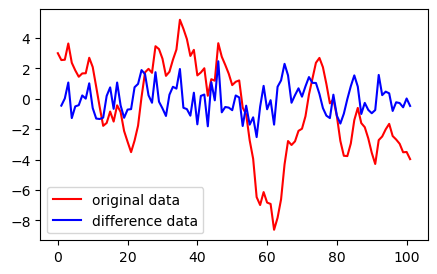

In [10]:
### Use difference method to make the data stationary
### step 1: plot the original data
x = range(len(data))
plt.figure(figsize=(5, 3))
plt.plot(x, data, 'r', label='original data')
def difference(data, interval=1):
    return [data[i+interval]-data[i] for i in range(len(data)-interval)]
difference_data = difference(data, 1)
plt.plot(x[1:], difference_data, 'b', label='difference data')
plt.legend(loc='best')
plt.show()

使用一次差分法为一阶差分，以此类推。此处我们发现一阶差分看起来有点周期性了。
接下来的问题是：怎么去验证它的平稳性呢？
首先，这个模型是自回归模型(auto-regressive)

自回归模型的公式:
$$
y_t=\mu+\sum_{i=1}^p \gamma_i y_{t-i}+\epsilon_t
$$

这里 $\gamma_i$ 是要求的参数, 而 $\varepsilon_t$ 是白噪声。在时间序列中, 最简单的平稳过程 (纯随机过程）就是白噪声过程。通过公式可以发现, 只要知道了 $x_{t-1}, \ldots \ldots, x_{t-p}$ 的值, 我们就能 求出 $x_t$.

这里引入一个延迟算子 $\mathrm{B}:$
这个B不是常数, 也不是函数, 有时可以把它当作一个变量。用当前序列值乘一个延迟算子, 就 相当于把当前时间序列向前拨动一个时刻。满足:
$$
x_{t-p}=B^p x_t(p \geq 1)
$$
有了这个算子, 自回归模型的公式可以写成:
$$
\left(1-\phi_1 B-\ldots \ldots \phi_p B^p\right) x_t=\varepsilon_t
$$
我们可以对 $x_t$ 左边的式子进行因式分解:
$$
\begin{aligned}
& \left(1-\phi_1 B-\ldots \ldots \phi_p B^p\right)=\left(1-\lambda_1 B\right)\left(1-\lambda_2 B\right) \ldots \ldots\left(1-\lambda_p B\right) \\
& \text { 令 }\left(1-\lambda_1 B\right)\left(1-\lambda_2 B\right) \ldots\left(1-\lambda_p B\right)=0
\end{aligned}
$$
这个方程的根为 $\frac{1}{\lambda_i}(1 \leq i \leq p)$

若这个方程有根在单位圆上，那么这个根就是单位根，即${\lambda_i}=1$

Unsolved: 为什么单位根就不是平稳的？什么是单位根？
https://zhuanlan.zhihu.com/p/581956595

In [11]:
result = ts.adfuller(difference_data)
print(result)

(-7.363630364114482, 9.359286534700414e-11, 0, 100, {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}, 249.1032477382544)


对该方法的解释：这个方法是假设有单位根, 而1\%代表有 $99 \%$ 的把握拒绝原假设, 5\%代表有 $95 \%$ 的把握来拒绝原假 设, $10 \%$ 代表有 $90 \%$ 的把握来拒绝原假设。
第一个数 (T检验, 假设检验值)约等于 $-7.36$ 小于 $1 \%$ 的 $-3.497$, 而且第二个数(数据不平稳的概率)也 很小, 所以可以拒绝原假设。

即difference_data是平稳序列


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


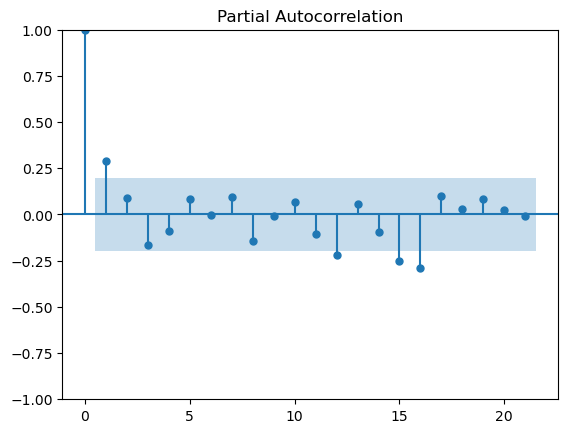

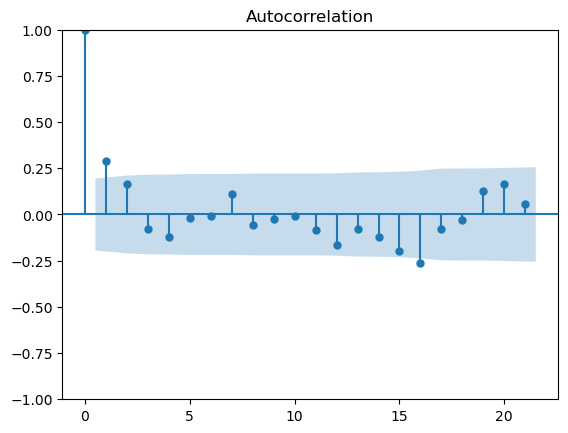

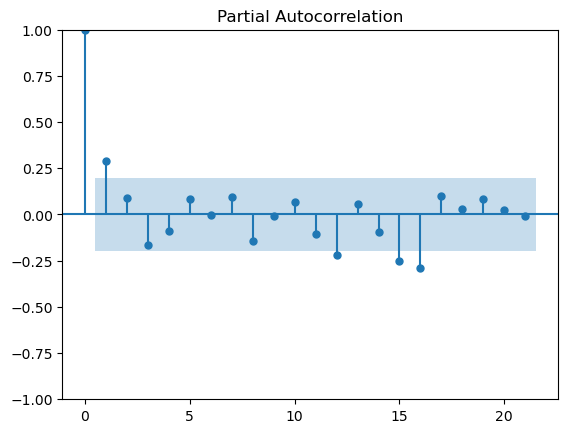

In [12]:
difference_data=np.array(difference_data)#类型转换，不然会报错
plot_acf(difference_data)
plot_pacf(difference_data)

这里ACF和PACF都是2阶拖尾。所以用ARMA模型。
- 拖尾：按规律递减
- 截尾：突然减至0（不一定是完全0，因为有白噪音项）
- 一个结论:
若偏自相关函数是截尾的, 而自相关函数是拖尾的, 则建立AR模型;
若偏自相关函数是拖尾的, 而自相关函数是截尾的, 则建立MA模型;
若偏自相关函数和自相关函数均是拖尾的, 则序列适合ARMA模型。

In [13]:
model = sm.tsa.arima.ARIMA(difference_data, order=(2,1,2))
result = model.fit()
print(result.summary())

/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  101
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -140.030
Date:                Sun, 01 Jan 2023   AIC                            290.060
Time:                        22:02:56   BIC                            303.086
Sample:                             0   HQIC                           295.332
                                - 101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0872      0.774     -0.113      0.910      -1.604       1.429
ar.L2          0.2250      0.188      1.194      0.232      -0.144       0.594
ma.L1         -0.6426      6.271     -0.102      0.9

移动平均模型 (MA )

移动平均模型关注的是自回归模型中的误差项的累加  
q阶自回归过程的公式定义 : $y_t=\mu+\epsilon_t+\sum_{i=1}^q \theta_i \epsilon_{t-i}$  
移动平均法能有效地消除预测中的随机波动

需要求p(AR)和q(MA)

自回归移动平均模型 (ARMA )  
自回归与移动平均的结合  
公式定义 : $y_t=\mu+\sum_{i=1}^R \gamma_i y_{t-i}+\epsilon_t+\sum_{i=1}^q \theta_i \epsilon_{t-i}$

ARIMA  
$\operatorname{ARIMA}(p, d, q)$ 模型全称为差分自回归移动平均模型
(Autoregressive Integrated Moving Average Model,i简记ARIMA)  
AR是自回归， $\mathrm{p}$ 为自回归项；MA为移动平均  
$q$ 为移动平均项数， $d$ 为时间序列成为平稳时所做的差分次数  
原理 : 将非平稳时间序列转化为平稳时间序列然后将因变量  
仅对它的滞后值以及随机误差项的现值和滞后值进行回归所建立的模型  

自相关函数ACF(autocorrelation function)  
有序的随机变量序列与其自身相比较 自相关函数反映了同一序列在不同时序的取值之间的相关性  
公式: $A C F(k)=\rho_k=\frac{\operatorname{Cov}\left(y_t, y_{t-k}\right)}{\operatorname{Var}\left(y_t\right)}$  
$P k$ 的取值范围为 $[-1,1]$

偏自相关函数(PACF)(partial autocorrelation function)  
对于一个平稳AR(p)模型，求出滞后 $k$ 自相关系数 $p(k)$ 时 实际上得到并不是 $x(t)$ 与 $x(t-k)$ 之间单纯的相关关系 而这 $k-1$ 个随机变量又都和 $x(t-k)$ 具有相关关系 所以自相关系数 $p(k)$ 里实际掺杂了其他变量对 $x(t)$ 与 $x(t-k)$ 的影响  
剔除了中间 $\mathrm{k}-1$ 个随机变量 $x(\mathrm{t}-1) 、 \mathrm{x}(\mathrm{t}-2) 、 \ldots \ldots . \mathrm{x}(\mathrm{t}-\mathrm{k}+1)$ 的干扰之后 $\mathrm{x}(\mathrm{t}-\mathrm{k}) \mathrm{z} \mathrm{x}(\mathrm{t})$ 影响的相关程度。  
ACF还包含了其他变量的影响  
而偏自相关系数PACF是严格这两个变量之间的相关性

确定阶数：![](https://cdn.mathpix.com/snip/images/GpUS2iTPvh1m5HFKf_GPQgKmcSN7CvjNavf4CKGADFk.original.fullsize.png) 
$$
\text { 截尾 : 落在置信区间内 ( 95\%的点都符合该规则 ) }
$$

### 实例分析


      value        date
0  156309.0  1952-01-01
1  156527.0  1952-02-01
2  156731.0  1952-03-01
3  156943.0  1952-04-01
4  157140.0  1952-05-01
816


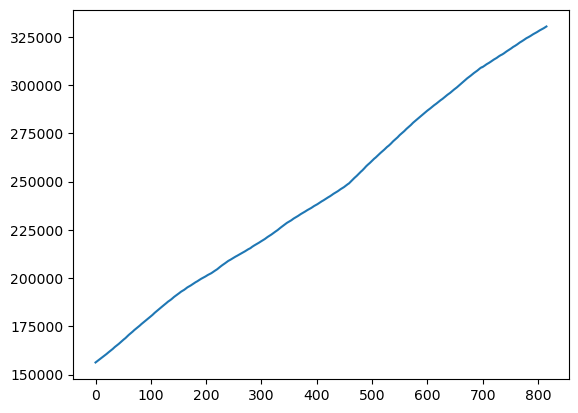

In [14]:
### step 1: load csv
data = pd.read_csv('POP.csv')
### Check if the path is correct
if(data.empty):
    print('The path is not correct')
### Show the summary of the data
### Cut the first column and the last column
data = data.iloc[:,1:-1]
print(data[:5])
### Check if there is any missing value
if data.isnull().values.any():
    print('There is missing value')
### plot the data
time = np.arange(0, len(data['value']), 1)
print(len(time))
plt.plot(time,data['value'])

(-2.0098954212892877, 0.28225122766444255, 21, 793, {'1%': -3.438623132449471, '5%': -2.8651915799370014, '10%': -2.568714441670417}, 6580.032300639022)
(-7.221127817898136, 2.1100121875841674e-10, 21, 792, {'1%': -3.438633612472885, '5%': -2.865196199232788, '10%': -2.5687169024206713}, 6560.129833849592)


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


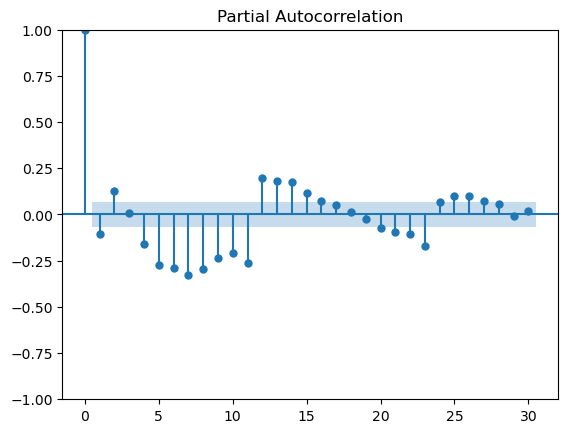

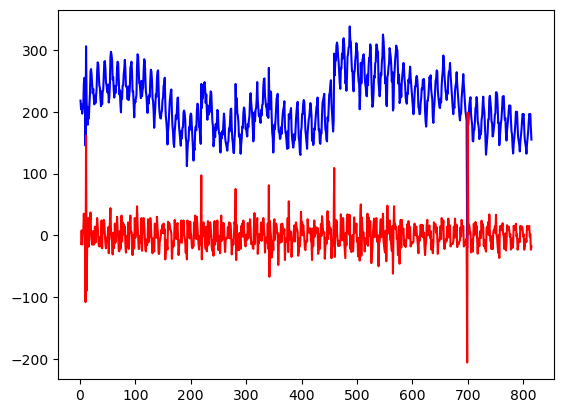

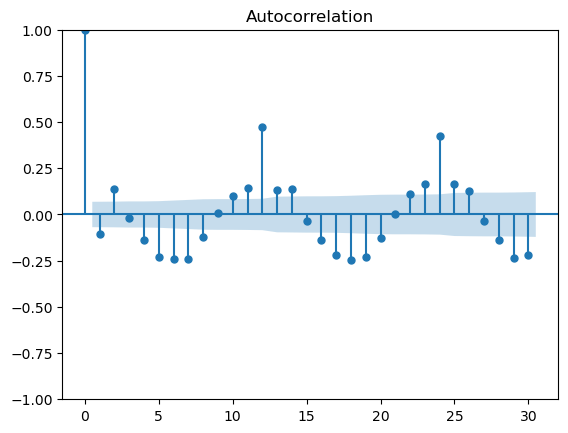

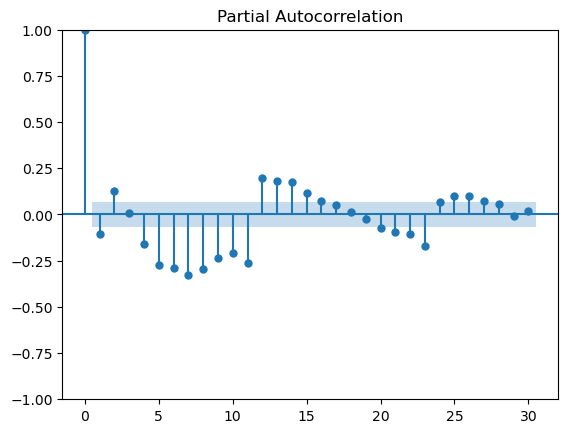

In [15]:
difference_data = difference(data['value'], 1)
plt.plot(time[1:], difference_data, 'b', label='difference data')
difference_data2 = difference(difference_data, 1)
plt.plot(time[2:], difference_data2, 'r', label='difference data2')
### Check if the data is stationary
result1 = ts.adfuller(difference_data)
result2 = ts.adfuller(difference_data2)
print(result1)
print(result2)
### Here the second difference data is stationary
### Then we can analyze the data
difference_data2=np.array(difference_data2)#类型转换，不然会报错
plot_acf(difference_data2)
plot_pacf(difference_data2)



In [20]:
# Both are tailing, so we can use ARIMA model
model = sm.tsa.arima.ARIMA(data['value'], order=(3, 2, 3))
result = model.fit()
prediction = result.predict(start=0, end=100)


/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/SILENT/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


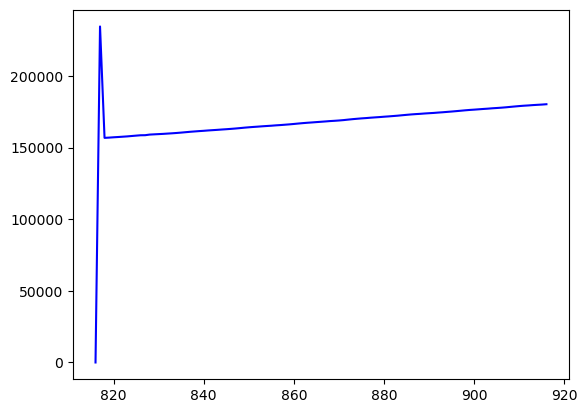

In [22]:
### plot the original data together with the predicted data
predict_time = np.arange(len(data['value']), len(data['value'])+len(prediction), 1)
#plt.plot(time,data['value'], 'r')
plt.plot(predict_time,prediction, 'b')
plt.show()